In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [66]:
def true_dist(x) -> float:
    return math.sqrt(x[0]**2 + x[1]**2)

def fit_dist(x, a: float, b: float, c: float) -> float:
    y = np.abs(x[1])
    x = np.abs(x[0])
    mi = np.minimum(x, y)
    ma = np.maximum(x, y)
    return ma + 0.4142135623730950488016 * mi + a * ma * mi + b * ma * ma + c * mi * mi

In [69]:
def generate_data(n: int) -> np.ndarray:
    # random points in a square
    x = (np.random.rand(n, 2) * 2 - 1) * 100000000
    y = np.array([true_dist(x[i]) for i in range(n)])
    return x, y

def plot_data(x, y):
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis')
    plt.colorbar()
    plt.show()
    
def plot_model(x, y, model):
    y_pred = model(x)
    plt.scatter(x, y, c=y_pred.detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()
    
def plot_loss(losses):
    plt.plot(losses)
    plt.show()
    
def plot_error(errors):
    plt.plot(errors)
    plt.show()
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        
    def forward(self, x):
        y = torch.abs(x[:, 1])
        x = torch.abs(x[:, 0])
        mi = torch.min(x, y)
        ma = torch.max(x, y)
        return ma + 0.4142135623730950488016 * mi + self.a * ma * mi + self.b * ma * ma + self.c * mi * mi
    
    def string(self):
        return f'Net(a={self.a.item()}, b={self.b.item()}, c={self.c.item()})'
    
def train(model, x, y, optimizer, loss_fn, epochs: int):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def test(model, x, y):
    y_pred = model(x)
    return np.mean(np.abs(y_pred.detach().numpy() - y))

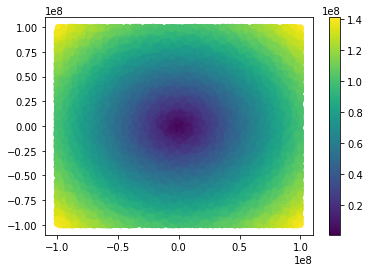

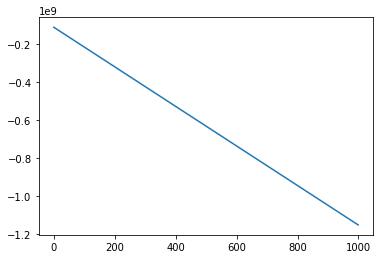

1.0155872845021946e+17
Net(a=11.363466262817383, b=11.230569839477539, c=10.082894325256348)


In [77]:

x, y = generate_data(50000)
plot_data(x, y)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# custom loss function
def loss_fn(y_pred, y):
    return torch.mean(1-torch.abs(y_pred)/torch.abs(y))

losses = train(model, torch.tensor(x).float(), torch.tensor(y).float(), optimizer, loss_fn, 1000)
plot_loss(losses)

x, y = generate_data(10000)
error = test(model, torch.tensor(x).float(), y)
print(error)

# print parameters
print(model.string())

In [78]:
import timeit
import math

In [109]:
# benchmark

def f1(d):
    return math.sqrt(d[0]**2 + d[1]**2)

def f2(d):
    y = abs(d[1])
    x = abs(d[0])
    mi = min(x, y)
    ma = max(x, y)
    return ma + 0.4142135623730950488016 * mi

def f3(d, eps=1e-8):
    a = d[0]**2 + d[1]**2
    x = f2(d)
    while abs(x * x - a) > eps:
        print("x:", x)
        x = (x + a / x) / 2
    return x



def benchmark():
    data = (np.random.rand(1000, 2) * 2 - 1) * 10
    for f in [f1, f2, f3]:
        print(timeit.timeit(lambda: [f(d) for d in data], number=1000))
    
    true_data = np.array([f1(d) for d in data])
    f2_data = np.array([f2(d) for d in data])
    f3_data = np.array([f3(d) for d in data])
    print(np.mean(np.abs(true_data - f2_data)))
    print(np.mean(np.abs(true_data - f3_data)))
        
D = (np.random.rand(2) * 2 - 1) * 10
test = f3(D, 1e-12)
test - math.sqrt(D[0]**2 + D[1]**2)

x: 5.3065996012772745
x: 4.992435197765919
x: 4.982550315086039
x: 4.982540509775563


0.0